In [71]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras import Model, Input, layers, models, Sequential
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from PIL import UnidentifiedImageError, ImageFile

In [72]:
encoder_path = 'model/model_final.keras'
decoder_path = 'model/decoder.keras'
DATA_DIR = "Plots"
train_interval = 600
val_interval = 700
test_interval = 700

In [73]:
def combine_encoder_decoder(encoder_path, decoder_path):
    encoder = load_model(encoder_path)
    decoder = load_model(decoder_path)

    input_shape = encoder.input_shape[1:]

    inputs = Input(shape=input_shape)

    latent_output = encoder(inputs)

    decoded_output = decoder(latent_output)
    
    full_model = Model(inputs=inputs, outputs=decoded_output, name="DualStageNetwork")

    full_model.compile(optimizer='adam', loss='mse')

    return full_model

In [74]:
def load_data(data_dir):
    # drive.mount('/content/drive')

    all_imgs = sorted(
        [os.path.join(data_dir, f) for f in os.listdir(data_dir) if f.lower().endswith(('.png', '.jpg', '.jpeg'))],
        key=lambda x: int(''.join(filter(str.isdigit, os.path.basename(x))))
    )

    # train_files, test_files = train_test_split(all_imgs, test_size=0.3, random_state=42)
    # val_files, test_files   = train_test_split(test_files, test_size=0.5, random_state=42)

    train_files = all_imgs[:train_interval]
    val_files   = all_imgs[train_interval:val_interval]
    test_files  = all_imgs[test_interval:]

    print(f"Train: {len(train_files)}, Val: {len(val_files)}, Test: {len(test_files)}")
    return train_files, val_files, test_files

In [75]:
def load_images(file_list):
    data = []
    for f in file_list:
        try:
            img = load_img(f, target_size=(128, 128), color_mode="rgb")
            arr = img_to_array(img) / 255.0
            data.append(arr)
        except (OSError, UnidentifiedImageError) as e:
            print(f"⚠️ Skipping corrupted image: {f} ({e})")
    return np.array(data)

In [76]:
def plot_result(autoencoder, X_signal, Y_target, num_images=5):

    preds = autoencoder.predict(X_signal[:num_images])

    plt.figure(figsize=(12, 9))

    for i in range(num_images):

        # 1. Plot INPUT SIGNAL (grayscale dari channel 0)
        plt.subplot(3, num_images, i+1)
        inp = X_signal[i]

        # Normalize untuk visualisasi
        norm = (inp[...,0] - inp[...,0].min()) / (inp[...,0].max() - inp[...,0].min() + 1e-8)

        plt.imshow(norm, cmap='gray')
        plt.title("Input Signal")
        plt.axis("off")


        # 2. TARGET IMAGE
        plt.subplot(3, num_images, i+1+num_images)
        plt.imshow(Y_target[i])
        plt.title("Target Image")
        plt.axis("off")


        # 3. RECONSTRUCTED
        plt.subplot(3, num_images, i+1+2*num_images)
        plt.imshow(preds[i])
        plt.title("Reconstructed")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


In [77]:
def create_cnn(input_shape, latent_dim):
  model = Sequential([
      Input(shape=input_shape),
      layers.Conv2D(16, (3,3), activation='relu', strides=1),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(32, (3,3), activation='relu', strides=1),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, (3,3), activation='relu', strides=1),
      layers.MaxPooling2D((2,2)),
      layers.Flatten(),
      layers.Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
      layers.Dense(latent_dim, activation='linear')
  ])
  return model

In [78]:
def build_decoder(img_size, latent_dim):
    inputs = layers.Input(shape=(latent_dim,))

    x = layers.Dense((img_size//32) * (img_size//32) * 128, activation="relu")(inputs)
    x = layers.Reshape((img_size//32, img_size//32, 128))(x)   # 4x4x128 jika img_size=128

    x = layers.Conv2DTranspose(128, (3,3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(128, (3,3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(64, (3,3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(64, (3,3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(32, (3,3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(32, (3,3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(16, (3,3), strides=2, activation="relu", padding="same")(x)
    x = layers.Conv2D(16, (3,3), activation="relu", padding="same")(x)

    x = layers.Conv2DTranspose(8, (3,3), strides=2, activation="relu", padding="same")(x)

    outputs = layers.Conv2D(3, (3,3), activation="sigmoid", padding="same")(x)

    return models.Model(inputs, outputs, name="Decoder")


In [79]:
X_signal = np.load("latent_rep/final_dataset_baru.npy")
X_signal_train = X_signal[:train_interval]
X_signal_val = X_signal[train_interval:val_interval]
X_signal_test = X_signal[test_interval:]

train_files, val_files, test_files = load_data(DATA_DIR)
train_data = load_images(train_files)
val_data   = load_images(val_files)
test_data  = load_images(test_files)

Train: 600, Val: 100, Test: 15


In [80]:
train_data.shape

(600, 128, 128, 3)

In [81]:
val_data.shape

(100, 128, 128, 3)

In [82]:
test_data.shape

(15, 128, 128, 3)

In [83]:
X_signal_test.shape

(15, 24, 24, 2)

In [84]:
X_signal_train.shape

(600, 24, 24, 2)

In [85]:
X_signal_val.shape

(100, 24, 24, 2)

In [86]:
load_data(DATA_DIR)

Train: 600, Val: 100, Test: 15


(['Plots\\Scan1.png',
  'Plots\\Scan2.png',
  'Plots\\Scan3.png',
  'Plots\\Scan4.png',
  'Plots\\Scan5.png',
  'Plots\\Scan6.png',
  'Plots\\Scan7.png',
  'Plots\\Scan8.png',
  'Plots\\Scan9.png',
  'Plots\\Scan10.png',
  'Plots\\Scan11.png',
  'Plots\\Scan12.png',
  'Plots\\Scan13.png',
  'Plots\\Scan14.png',
  'Plots\\Scan15.png',
  'Plots\\Scan16.png',
  'Plots\\Scan17.png',
  'Plots\\Scan18.png',
  'Plots\\Scan19.png',
  'Plots\\Scan20.png',
  'Plots\\Scan21.png',
  'Plots\\Scan22.png',
  'Plots\\Scan23.png',
  'Plots\\Scan24.png',
  'Plots\\Scan25.png',
  'Plots\\Scan26.png',
  'Plots\\Scan27.png',
  'Plots\\Scan28.png',
  'Plots\\Scan29.png',
  'Plots\\Scan30.png',
  'Plots\\Scan31.png',
  'Plots\\Scan32.png',
  'Plots\\Scan33.png',
  'Plots\\Scan34.png',
  'Plots\\Scan35.png',
  'Plots\\Scan36.png',
  'Plots\\Scan37.png',
  'Plots\\Scan38.png',
  'Plots\\Scan39.png',
  'Plots\\Scan40.png',
  'Plots\\Scan41.png',
  'Plots\\Scan42.png',
  'Plots\\Scan43.png',
  'Plots\\Scan44.png

In [87]:
encoder = create_cnn(input_shape=(24,24,2), latent_dim=256)
decoder = build_decoder(img_size=128, latent_dim=256)

inputs = tf.keras.Input(shape=(24,24,2))
latent = encoder(inputs)
outputs = decoder(latent)

autoencoder = tf.keras.Model(inputs, outputs)
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')

In [88]:
autoencoder.fit(X_signal_train, train_data, epochs=50, batch_size=4, validation_data=(X_signal_val, val_data))

Epoch 1/50
150/150 [==============================] - 2s 7ms/step - loss: 0.8965 - val_loss: 0.5608
Epoch 2/50
150/150 [==============================] - 1s 5ms/step - loss: 0.5403 - val_loss: 0.5347
Epoch 3/50
150/150 [==============================] - 1s 4ms/step - loss: 0.5329 - val_loss: 0.5333
Epoch 4/50
150/150 [==============================] - 1s 4ms/step - loss: 0.5315 - val_loss: 0.5319
Epoch 5/50
150/150 [==============================] - 1s 4ms/step - loss: 0.5310 - val_loss: 0.5324
Epoch 6/50
150/150 [==============================] - 1s 4ms/step - loss: 0.5304 - val_loss: 0.5303
Epoch 7/50
150/150 [==============================] - 1s 4ms/step - loss: 0.5267 - val_loss: 0.5275
Epoch 8/50
150/150 [==============================] - 1s 4ms/step - loss: 0.5235 - val_loss: 0.5240
Epoch 9/50
150/150 [==============================] - 1s 4ms/step - loss: 0.5219 - val_loss: 0.5218
Epoch 10/50
150/150 [==============================] - 1s 4ms/step - loss: 0.5203 - val_loss: 0.5217

In [89]:
# full_model = combine_encoder_decoder(encoder_path, decoder_path)
# full_model.summary()
# full_model.fit(X_signal[:500], train_data, epochs=10, batch_size=16)

1/1 [==============================] - 0s 84ms/step


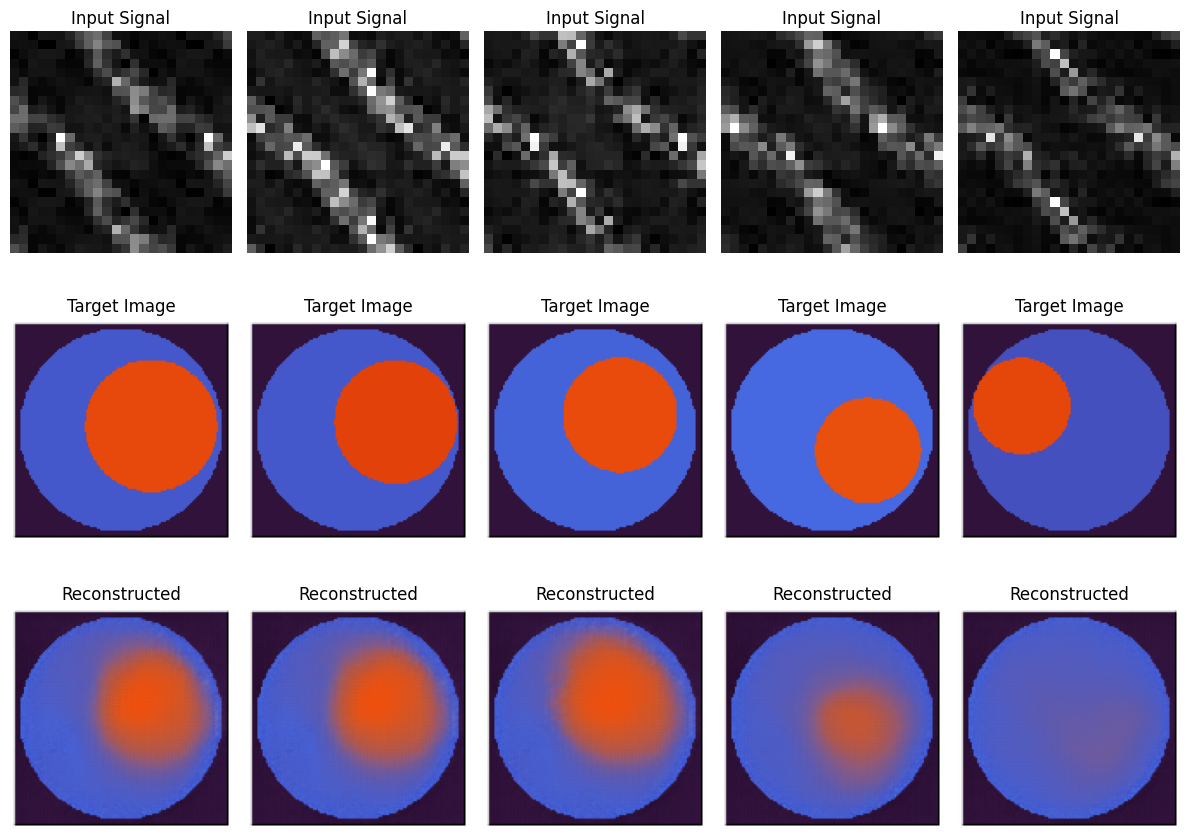

In [90]:
plot_result(autoencoder, X_signal_train, train_data)
